<a href="https://colab.research.google.com/github/tasmimjoti/Computer-Vision/blob/main/Final_Blood_Group_Prediction_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import glob
import random
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/Blood Group Detection/dataset_blood_group"

In [ ]:
if os.path.exists(DATASET_PATH):
    print("Dataset path exists.")
else:
    print("Dataset path does NOT exist. Check the path.")

Dataset path exists.


In [ ]:
folders = os.listdir(DATASET_PATH)
print("Folders inside dataset:", folders)

Folders inside dataset: ['AB+', 'O-', 'B-', 'B+', 'A-', 'O+', 'A+', 'AB-']


In [ ]:
for folder in os.listdir(DATASET_PATH):
    folder_path = os.path.join(DATASET_PATH, folder)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        print(f"📁 {folder} → {len(images)} images")
        print(f"🔹 Sample images: {images[:5]}")  # Show first 5 images

📁 AB+ → 708 images
🔹 Sample images: ['cluster_4_107.BMP', 'cluster_4_1193.BMP', 'cluster_4_1162.BMP', 'cluster_4_1016.BMP', 'cluster_4_103.BMP']
📁 O- → 712 images
🔹 Sample images: ['cluster_7_1263.BMP', 'cluster_7_1234.BMP', 'cluster_7_1207.BMP', 'cluster_7_1343.BMP', 'cluster_7_1392.BMP']
📁 B- → 741 images
🔹 Sample images: ['cluster_3_1032.BMP', 'cluster_3_1274.BMP', 'cluster_3_1280.BMP', 'cluster_3_1201.BMP', 'cluster_3_1291.BMP']
📁 B+ → 652 images
🔹 Sample images: ['cluster_2_1135.BMP', 'cluster_2_1231.BMP', 'cluster_2_1336.BMP', 'cluster_2_1248.BMP', 'cluster_2_1325.BMP']
📁 A- → 1009 images
🔹 Sample images: ['cluster_1_1007.BMP', 'cluster_1_124.BMP', 'cluster_1_1011.BMP', 'cluster_1_1163.BMP', 'cluster_1_1155.BMP']
📁 O+ → 852 images
🔹 Sample images: ['cluster_6_1033.BMP', 'cluster_6_106.BMP', 'cluster_6_1065.BMP', 'cluster_6_1039.BMP', 'cluster_6_1057.BMP']
📁 A+ → 565 images
🔹 Sample images: ['cluster_0_1578.BMP', 'cluster_0_3102.BMP', 'cluster_0_1851.BMP', 'cluster_0_1367.BMP', 'c

In [ ]:
def load_dataset(dataset_path):
    X, y = [], []
    labels = sorted(os.listdir(dataset_path))

    for label in labels:
        label_path = os.path.join(dataset_path, label)
        if not os.path.isdir(label_path):
            continue

        print(f"🔍 Processing folder: {label}")

        # Match both lowercase and uppercase BMP files
        image_paths = glob.glob(os.path.join(label_path, "*.bmp")) + glob.glob(os.path.join(label_path, "*.BMP"))

        if not image_paths:
            print(f"⚠️ No BMP images found in {label_path}")
            continue  # Skip this folder if no images found

        for img_path in image_paths:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"❌ Failed to read: {img_path}")
                continue

            # ✅ Apply CLAHE for contrast enhancement
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            img = clahe.apply(img)

            # Resize to 75x75 for InceptionV3 compatibility and flatten
            img = cv2.resize(img, (64, 64))
            img = img.flatten()

            X.append(img)
            y.append(label)

    print(f"✅ Total images loaded: {len(X)}")
    return np.array(X), np.array(y)

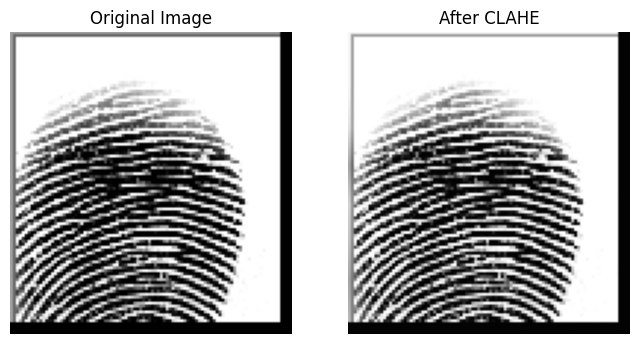

In [ ]:
import matplotlib.pyplot as plt

def show_clahe_effect(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Error: Could not read image from {image_path}")
        return

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(img)

    # Show original vs enhanced
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap="gray", vmin=0, vmax=255)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(enhanced_img, cmap="gray", vmin=0, vmax=255)
    plt.title("After CLAHE")
    plt.axis("off")

    plt.show()

# Test on a sample image from the dataset path
# Construct the sample image path using the DATASET_PATH variable and a known file
sample_image_path = os.path.join(DATASET_PATH, "AB+", "cluster_4_100.BMP")
show_clahe_effect(sample_image_path)

In [ ]:
X, y = load_dataset(DATASET_PATH)

🔍 Processing folder: A+
🔍 Processing folder: A-
🔍 Processing folder: AB+
🔍 Processing folder: AB-
🔍 Processing folder: B+
🔍 Processing folder: B-
🔍 Processing folder: O+
🔍 Processing folder: O-
✅ Total images loaded: 6000


In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# Normalize X (Pixel values should be between 0 and 1)
X = X / 255.0
# Reshape for CNN input with the new image size
X = X.reshape(-1, 64, 64, 1)  # Reshape for CNN input with 64x64 images

In [ ]:
# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Define CNN Model
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(64, 64, 1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(len(label_encoder.classes_), activation="softmax")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.2501 - loss: 1.8725 - val_accuracy: 0.7733 - val_loss: 0.6460
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7075 - loss: 0.7838 - val_accuracy: 0.8108 - val_loss: 0.5061
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7767 - loss: 0.6263 - val_accuracy: 0.8458 - val_loss: 0.4153
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8069 - loss: 0.5237 - val_accuracy: 0.8625 - val_loss: 0.3761
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8190 - loss: 0.4696 - val_accuracy: 0.8700 - val_loss: 0.3259
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8401 - loss: 0.4414 - val_accuracy: 0.8867 - val_loss: 0.2953
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8537 - loss: 0.3941 - val_accuracy: 0.8758 - val_loss: 0.3319
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8656 - loss: 0.3645 - val_accuracy: 0

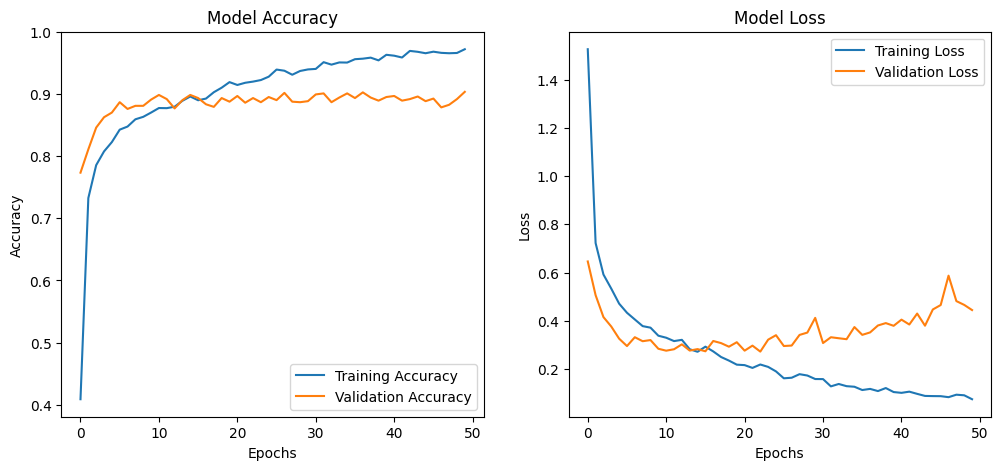

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    # Access history data using history.history
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    # Access history data using history.history
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Model Loss")
    plt.legend()

    plt.show()

# Pass the history object returned by model.fit
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
plot_training_history(history)

In [ ]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Improved Accuracy: {test_acc * 100:.2f}%")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9102 - loss: 0.4271
✅ Improved Accuracy: 90.33%


In [ ]:
y_pred = model.predict(X_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [ ]:
# Evaluate performance
accuracy = accuracy_score(y_test, y_pred.argmax(axis=1)) # Get predicted class labels
print(f"Model Accuracy: {accuracy:.4f}")

# Initialize and fit LabelEncoder
from sklearn.preprocessing import LabelEncoder  # Ensure LabelEncoder is imported
label_encoder = LabelEncoder()
label_encoder.fit(y) # Fit the encoder to your original labels (y)

print("Classification Report:\n", classification_report(y_test, y_pred.argmax(axis=1), target_names=label_encoder.classes_)) # Get predicted class labels

Model Accuracy: 0.9033
Classification Report:
               precision    recall  f1-score   support

          A+       0.91      0.93      0.92       135
          A-       0.90      0.89      0.90       216
         AB+       0.91      0.92      0.91       138
         AB-       0.88      0.89      0.88       132
          B+       0.90      0.95      0.93       129
          B-       0.95      0.90      0.92       140
          O+       0.89      0.91      0.90       172
          O-       0.89      0.85      0.87       138

    accuracy                           0.90      1200
   macro avg       0.90      0.90      0.90      1200
weighted avg       0.90      0.90      0.90      1200



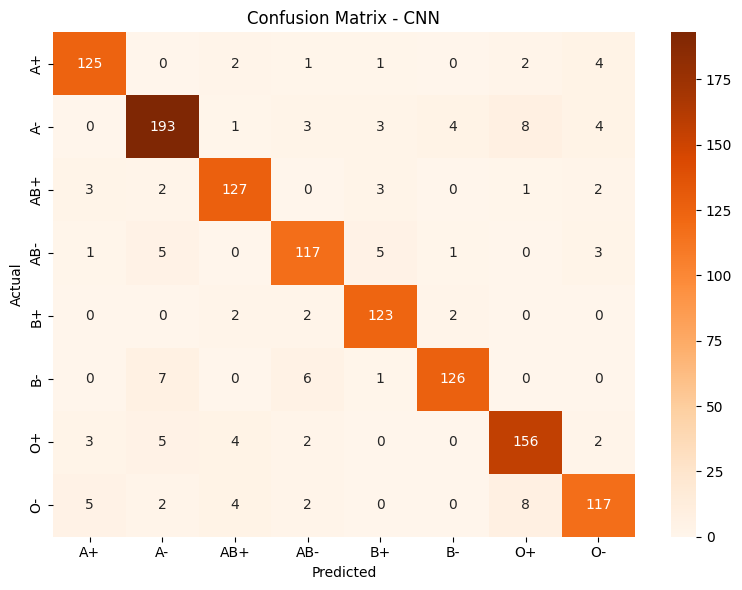

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred.argmax(axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CNN')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


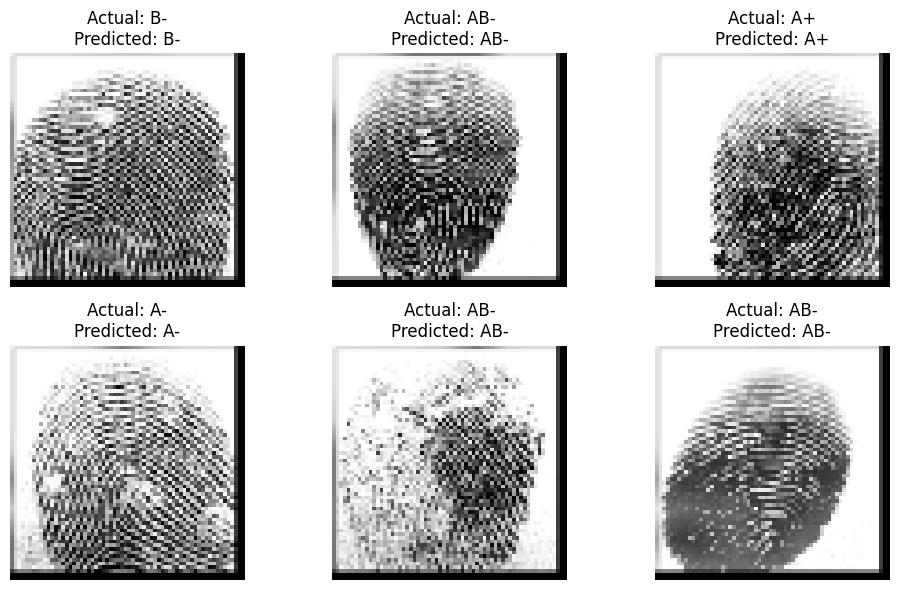

In [ ]:
def show_predictions(model, X_test, y_test, label_encoder):
    plt.figure(figsize=(10, 6))

    for i in range(6):  # Show 6 test samples
        idx = random.randint(0, len(X_test) - 1)
        img = X_test[idx].reshape(64, 64)
        actual_label = label_encoder.inverse_transform([y_test[idx]])[0]

        # Predict label
        pred_label_index = np.argmax(model.predict(X_test[idx].reshape(1, 64, 64, 1)))
        pred_label = label_encoder.inverse_transform([pred_label_index])[0]

        plt.subplot(2, 3, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Actual: {actual_label}\nPredicted: {pred_label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_predictions(model, X_test, y_test, label_encoder)

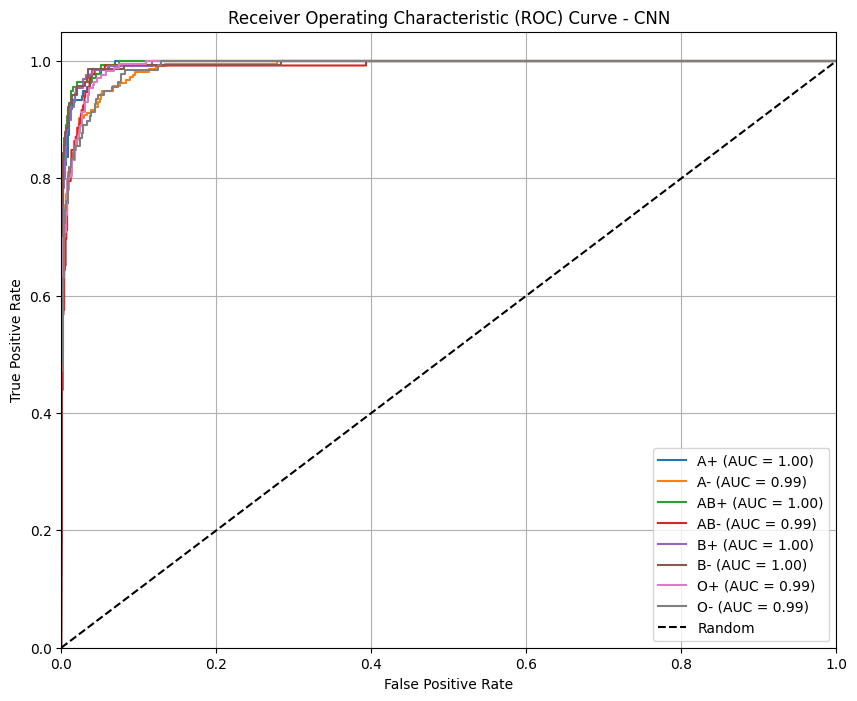

In [ ]:
# Compute ROC curve and ROC area for each class
n_classes = len(label_encoder.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - CNN')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)          │ (None, 2, 2, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │        65,544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,723,720 (162.98 MB)

 Trainable params: 65,544 (256.03 KB)

 Non-trainable params: 42,658,176 (162.73 MB)

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 33s 102ms/step - accuracy: 0.1671 - loss: 2.0804 - val_accuracy: 0.2817 - val_loss: 1.8566
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.3227 - loss: 1.8318 - val_accuracy: 0.3583 - val_loss: 1.7308
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.3609 - loss: 1.7151 - val_accuracy: 0.4158 - val_loss: 1.6538
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4038 - loss: 1.6679 - val_accuracy: 0.3950 - val_loss: 1.6012
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4253 - loss: 1.5881 - val_accuracy: 0.4417 - val_loss: 1.5539
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.4204 - loss: 1.5469 - val_accuracy: 0.4483 - val_loss: 1.4953
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4457 - loss: 1.5081 - val_accuracy: 0.4733 - val_loss: 1.4565
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4465 - loss: 1.4942 - val_ac

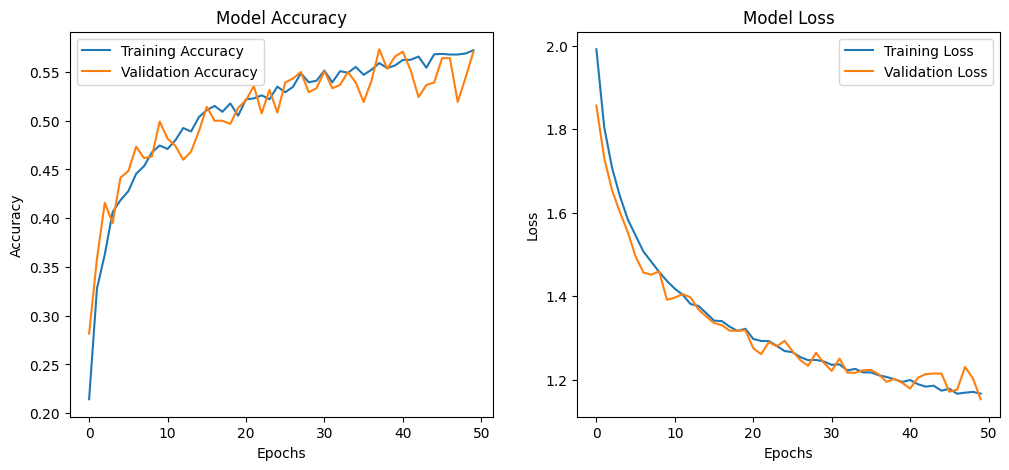

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5683 - loss: 1.1523
✅ Improved Accuracy: 57.08%
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 198ms/step


In [ ]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Load the ResNet101 model with pre-trained ImageNet weights
# Include_top=False removes the classification layer at the top
# input_shape should match the input dimensions of your preprocessed images
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(64, 64, 3)) # ResNet requires 3 input channels

# Freeze the layers of the base model so they are not trained
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the base model
# Since ResNet expects 3 channels, we need to adjust our data loading or add a conversion layer
# For simplicity here, we'll assume you'll modify the data loading to output 3 channels (e.g., stacking the grayscale channel)
model = Sequential([
    base_model,
    Flatten(),
    Dense(len(label_encoder.classes_), activation='softmax') # Add a new dense layer for your classification task
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary to see the layers
model.summary()

# Before training, you'll need to make sure your X_train and X_test
# have the correct shape (number of samples, 64, 64, 3)
# If your current data is (number of samples, 64, 64, 1), you can convert it like this:
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Then train the model with the new RGB data:
history = model.fit(X_train_rgb, y_train, epochs=50, batch_size=32, validation_data=(X_test_rgb, y_test))
plot_training_history(history)

# Evaluate the model with the new RGB data:
test_loss, test_acc = model.evaluate(X_test_rgb, y_test)
print(f"✅ Improved Accuracy: {test_acc * 100:.2f}%")

# Make predictions with the new RGB data:
y_pred = model.predict(X_test_rgb)

ResNet101 Model Accuracy: 0.5708
ResNet101 Classification Report:
               precision    recall  f1-score   support

          A+       0.57      0.64      0.61       135
          A-       0.43      0.73      0.54       216
         AB+       0.63      0.73      0.68       138
         AB-       0.52      0.52      0.52       132
          B+       0.73      0.66      0.69       129
          B-       0.76      0.64      0.69       140
          O+       0.55      0.13      0.21       172
          O-       0.62      0.55      0.58       138

    accuracy                           0.57      1200
   macro avg       0.60      0.57      0.57      1200
weighted avg       0.59      0.57      0.55      1200



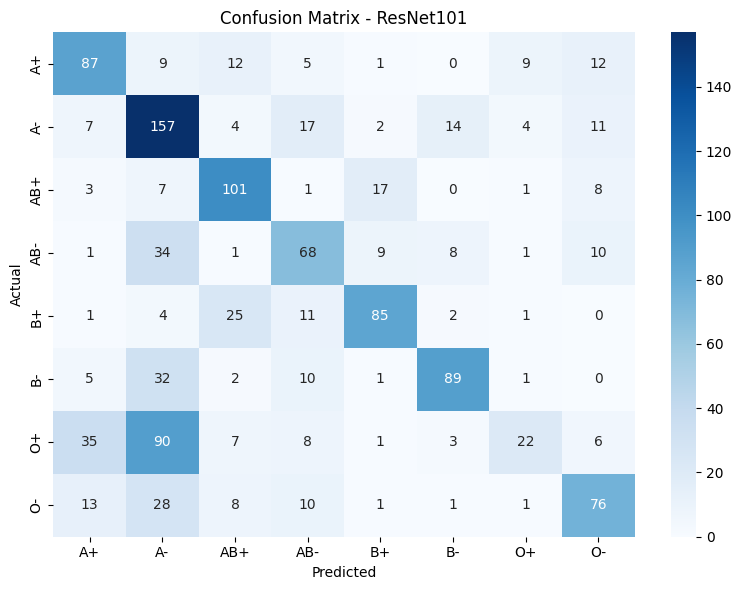

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


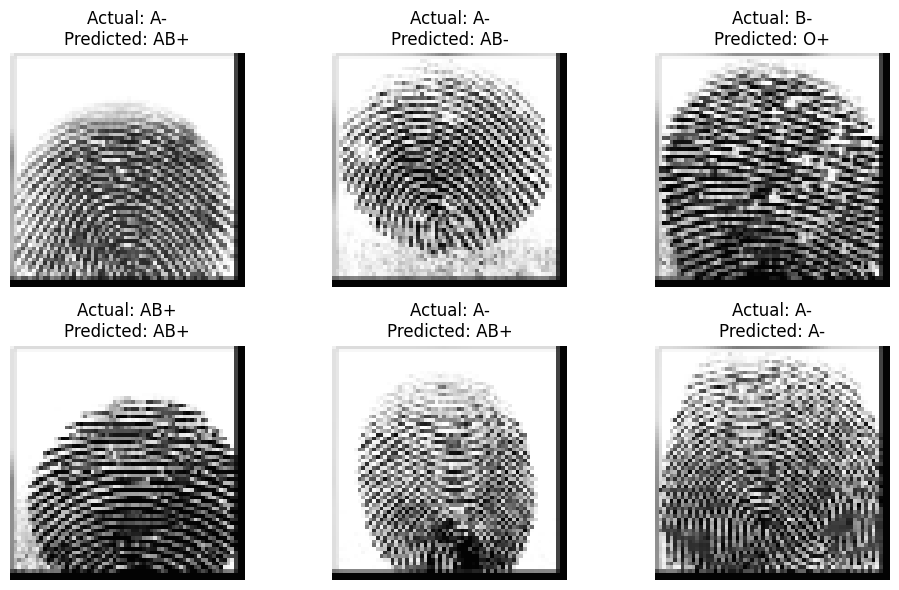

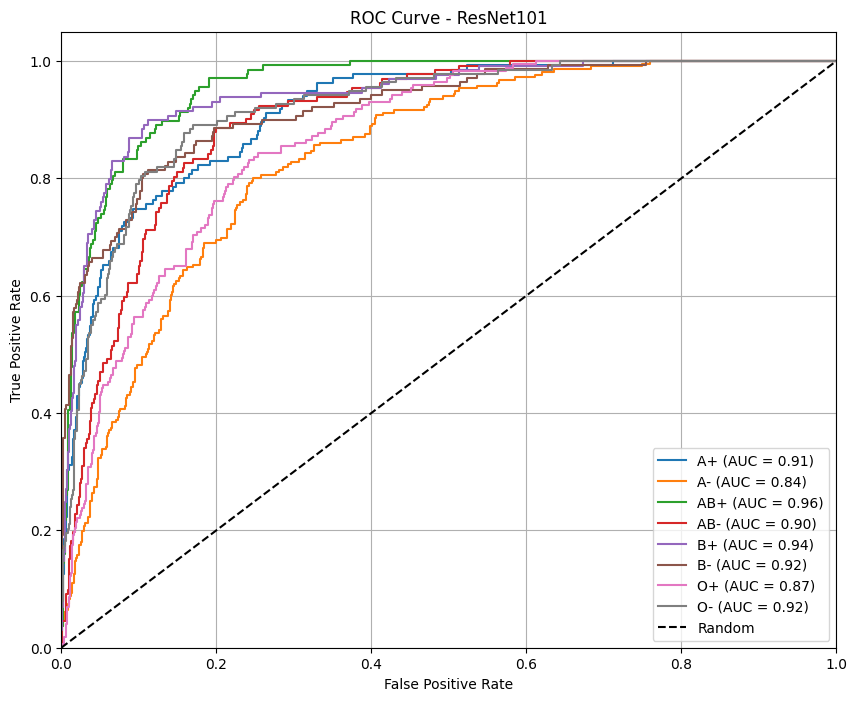

In [ ]:
# Classification Metrics
accuracy = accuracy_score(y_test, y_pred.argmax(axis=1))
print(f"ResNet101 Model Accuracy: {accuracy:.4f}")

print("ResNet101 Classification Report:\n", classification_report(y_test, y_pred.argmax(axis=1), target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred.argmax(axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - ResNet101')
plt.tight_layout()
plt.show()

# Sample Predictions for ResNet101
def show_predictions_resnet(model, X_test, y_test, label_encoder):
    plt.figure(figsize=(10, 6))

    for i in range(6):  # Show 6 test samples
        idx = random.randint(0, len(X_test) - 1)
        img = X_test[idx] # X_test is already in RGB format here
        actual_label = label_encoder.inverse_transform([y_test[idx]])[0]

        # Predict label
        # Ensure the input shape for prediction is (1, 64, 64, 3)
        pred_prob = model.predict(img.reshape(1, 64, 64, 3))
        pred_label_index = np.argmax(pred_prob)
        pred_label = label_encoder.inverse_transform([pred_label_index])[0]

        plt.subplot(2, 3, i + 1)
        # Rescale pixel values back to 0-255 for display if needed, or adjust cmap
        # If X_test_rgb was scaled to 0-1, multiply by 255 for display
        plt.imshow((img * 255).astype(np.uint8))
        plt.title(f"Actual: {actual_label}\nPredicted: {pred_label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_predictions_resnet(model, X_test_rgb, y_test, label_encoder)


# ROC Curves for ResNet101
n_classes = len(label_encoder.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    # y_test == i creates a binary array (True/False) for each class
    # y_pred[:, i] gets the predicted probability for the current class
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - ResNet101')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# Resize images to 75x75 and convert to RGB for InceptionV3 and MobileNetV2
X_resized = []
for img in X:
    # Reshape back to 2D to resize
    img_2d = img.reshape(64, 64)
    resized_img = cv2.resize(img_2d, (75, 75))
    # Convert grayscale to RGB by repeating the channel 3 times
    resized_img_rgb = np.repeat(resized_img[:, :, np.newaxis], 3, axis=2)
    X_resized.append(resized_img_rgb)

X_resized = np.array(X_resized)

# Split the resized data for transfer learning models
X_train_resized, X_test_resized, y_train_resized, y_test_resized = train_test_split(X_resized, y_encoded, test_size=0.2, random_state=42)

print("Data resized to 75x75 and converted to RGB for transfer learning models.")
print(f"X_train_resized shape: {X_train_resized.shape}")
print(f"X_test_resized shape: {X_test_resized.shape}")

Data resized to 75x75 and converted to RGB for transfer learning models.
X_train_resized shape: (4800, 75, 75, 3)
X_test_resized shape: (1200, 75, 75, 3)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 1, 1, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │        16,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,819,176 (83.23 MB)

 Trainable params: 16,392 (64.03 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

Training InceptionV3 Model...
Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.3033 - loss: 1.8703 - val_accuracy: 0.4800 - val_loss: 1.3901
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5068 - loss: 1.3402 - val_accuracy: 0.5067 - val_loss: 1.3309
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5675 - loss: 1.1909 - val_accuracy: 0.5100 - val_loss: 1.2890
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5979 - loss: 1.1239 - val_accuracy: 0.4825 - val_loss: 1.3365
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6364 - loss: 1.0277 - val_accuracy: 0.5083 - val_loss: 1.2699
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6537 - loss: 0.9737 - val_accuracy: 0.5117 - val_loss: 1.2631
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6645 - loss: 0.9506 - val_accuracy: 0.5092 - val_loss: 1.2717
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0

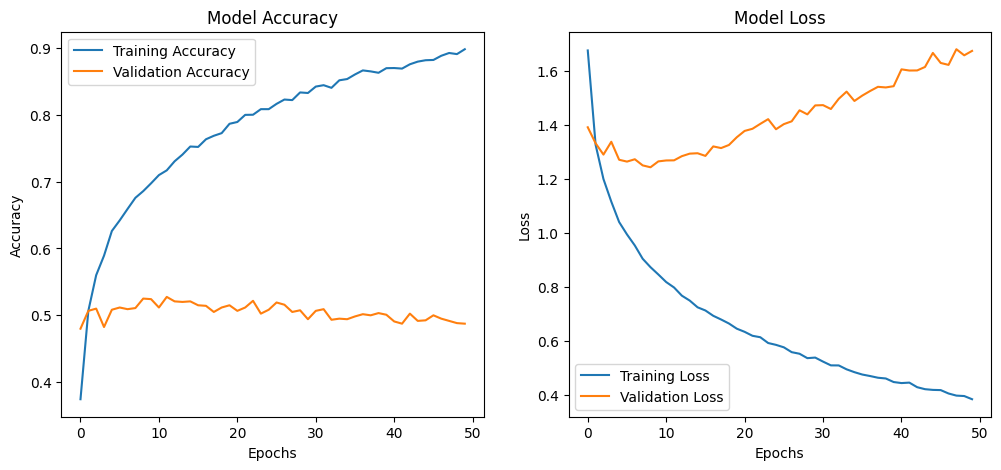

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5082 - loss: 1.6408
✅ InceptionV3 Accuracy: 48.75%
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import array_to_img

# Load the InceptionV3 model with pre-trained ImageNet weights
# Include_top=False removes the classification layer at the top
# input_shape should match the input dimensions of your preprocessed images (needs 3 channels)
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

# Freeze the layers of the base model
for layer in base_model_inception.layers:
    layer.trainable = False

# Create a new model on top of the base model
model_inception = Sequential([
    base_model_inception,
    Flatten(),
    Dense(len(label_encoder.classes_), activation='softmax') # Add a new dense layer for your classification task
])

# Compile the model
model_inception.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Print the model summary
model_inception.summary()


# Train the model with the new RGB data:
print("Training InceptionV3 Model...")
history_inception = model_inception.fit(X_train_resized, y_train_resized, epochs=50, batch_size=32, validation_data=(X_test_resized, y_test_resized))

# Plot training history for InceptionV3
plot_training_history(history_inception)

# Evaluate the InceptionV3 model with the new RGB data:
test_loss_inception, test_acc_inception = model_inception.evaluate(X_test_resized, y_test_resized)
print(f"✅ InceptionV3 Accuracy: {test_acc_inception * 100:.2f}%")

# Make predictions with the new RGB data:
y_pred_inception = model_inception.predict(X_test_resized)

InceptionV3 Model Accuracy: 0.4875
InceptionV3 Classification Report:
               precision    recall  f1-score   support

          A+       0.69      0.43      0.53       135
          A-       0.49      0.49      0.49       216
         AB+       0.45      0.50      0.47       138
         AB-       0.49      0.52      0.50       132
          B+       0.47      0.41      0.44       129
          B-       0.49      0.62      0.55       140
          O+       0.42      0.38      0.40       172
          O-       0.50      0.58      0.54       138

    accuracy                           0.49      1200
   macro avg       0.50      0.49      0.49      1200
weighted avg       0.50      0.49      0.49      1200



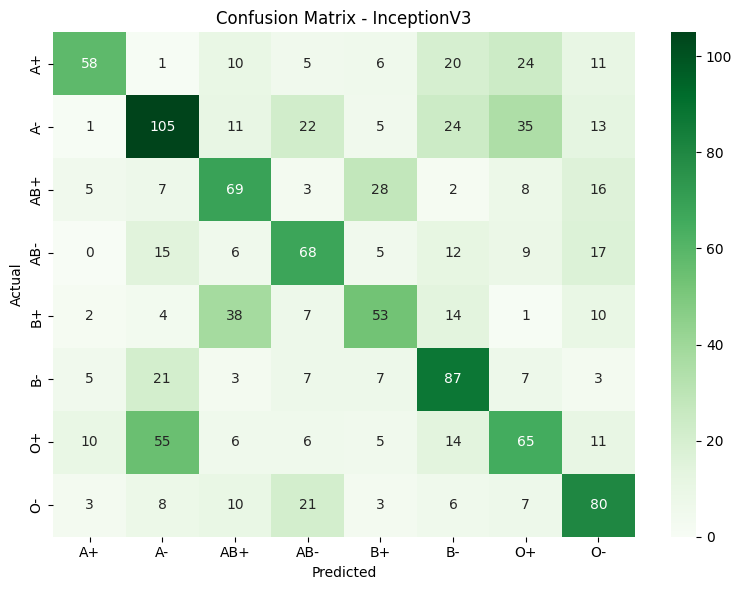

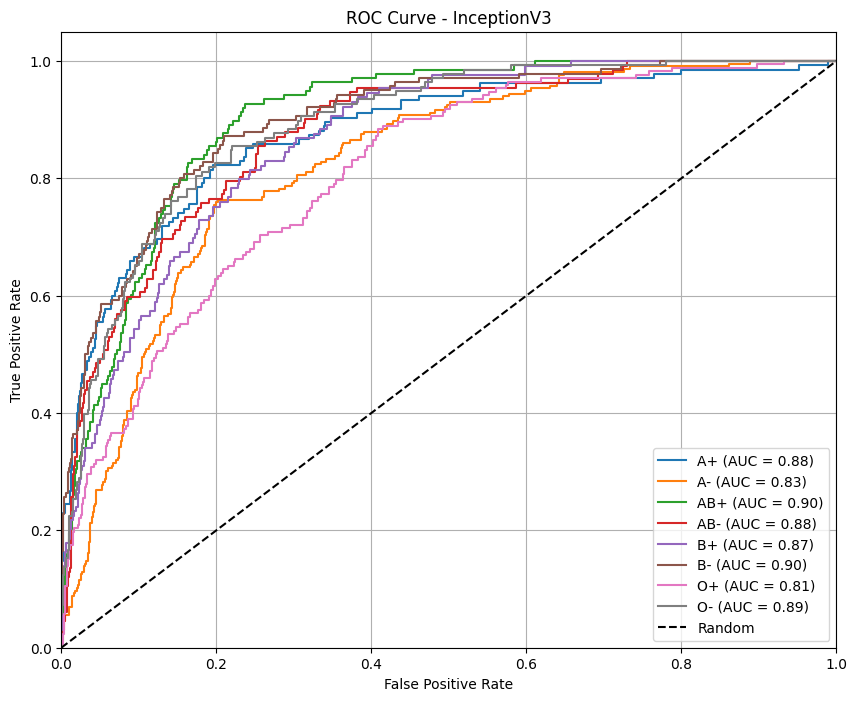

In [ ]:
# Classification Metrics for InceptionV3
accuracy_inception = accuracy_score(y_test_resized, y_pred_inception.argmax(axis=1))
print(f"InceptionV3 Model Accuracy: {accuracy_inception:.4f}")

print("InceptionV3 Classification Report:\n", classification_report(y_test_resized, y_pred_inception.argmax(axis=1), target_names=label_encoder.classes_))

# Confusion Matrix for InceptionV3
cm_inception = confusion_matrix(y_test_resized, y_pred_inception.argmax(axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_inception, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - InceptionV3')
plt.tight_layout()
plt.show()

# ROC Curves for InceptionV3
n_classes = len(label_encoder.classes_)
fpr_inception = dict()
tpr_inception = dict()
roc_auc_inception = dict()
for i in range(n_classes):
    # y_test == i creates a binary array (True/False) for each class
    # y_pred_inception[:, i] gets the predicted probability for the current class
    fpr_inception[i], tpr_inception[i], _ = roc_curve(y_test_resized == i, y_pred_inception[:, i])
    roc_auc_inception[i] = auc(fpr_inception[i], tpr_inception[i])

# Plot ROC curves for InceptionV3
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr_inception[i], tpr_inception[i], label=f'{label_encoder.classes_[i]} (AUC = {roc_auc_inception[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - InceptionV3')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Load the MobileNetV2 model with pre-trained ImageNet weights
# Include_top=False removes the classification layer at the top
# input_shape should match the input dimensions of your preprocessed images (needs 3 channels)
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

# Freeze the layers of the base model
for layer in base_model_mobilenet.layers:
    layer.trainable = False

# Create a new model on top of the base model
model_mobilenet = Sequential([
    base_model_mobilenet,
    Flatten(),
    Dense(len(label_encoder.classes_), activation='softmax') # Add a new dense layer for your classification task
])

# Compile the model
model_mobilenet.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Print the model summary
model_mobilenet.summary()

/tmp/ipython-input-97188357.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(75, 75, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │        92,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,350,152 (8.97 MB)

 Trainable params: 92,168 (360.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Training MobileNetV2 Model...
Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - accuracy: 0.3420 - loss: 5.7352 - val_accuracy: 0.5792 - val_loss: 1.7982
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5958 - loss: 1.6968 - val_accuracy: 0.6400 - val_loss: 1.2389
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6629 - loss: 1.2597 - val_accuracy: 0.5692 - val_loss: 2.3097
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5978 - loss: 2.0209 - val_accuracy: 0.6758 - val_loss: 1.3451
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7310 - loss: 1.0152 - val_accuracy: 0.6425 - val_loss: 1.6889
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7072 - loss: 1.2540 - val_accuracy: 0.6683 - val_loss: 1.5259
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7562 - loss: 0.9579 - val_accuracy: 0.6433 - val_loss: 1.9079
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.73

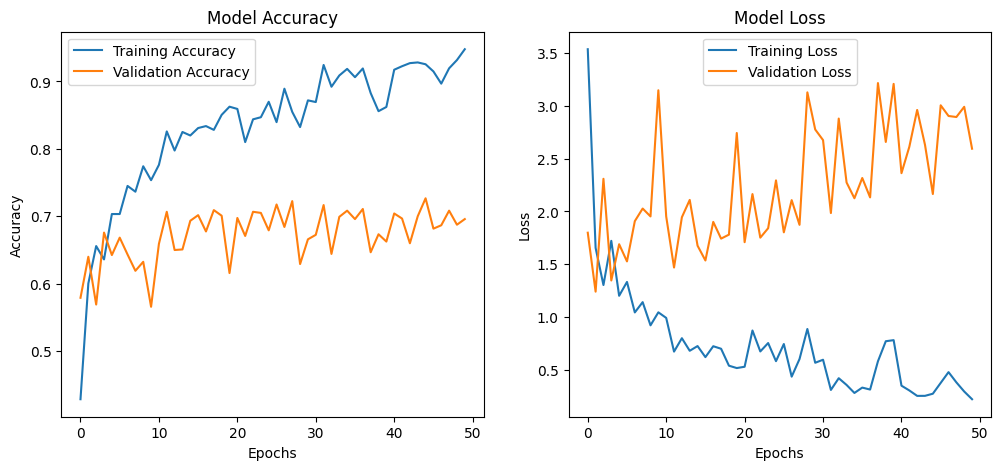

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6996 - loss: 2.7096
✅ MobileNetV2 Accuracy: 69.58%
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step


In [ ]:
# Train the MobileNetV2 model
print("Training MobileNetV2 Model...")
history_mobilenet = model_mobilenet.fit(X_train_resized, y_train_resized, epochs=50, batch_size=32, validation_data=(X_test_resized, y_test_resized))

# Plot training history for MobileNetV2
plot_training_history(history_mobilenet)

# Evaluate the MobileNetV2 model
test_loss_mobilenet, test_acc_mobilenet = model_mobilenet.evaluate(X_test_resized, y_test_resized)
print(f"✅ MobileNetV2 Accuracy: {test_acc_mobilenet * 100:.2f}%")

# Make predictions with the MobileNetV2 model
y_pred_mobilenet = model_mobilenet.predict(X_test_resized)

MobileNetV2 Model Accuracy: 0.6958
MobileNetV2 Classification Report:
               precision    recall  f1-score   support

          A+       0.79      0.82      0.80       135
          A-       0.77      0.54      0.63       216
         AB+       0.76      0.63      0.69       138
         AB-       0.51      0.85      0.63       132
          B+       0.65      0.80      0.72       129
          B-       0.76      0.86      0.81       140
          O+       0.66      0.69      0.68       172
          O-       0.87      0.49      0.62       138

    accuracy                           0.70      1200
   macro avg       0.72      0.71      0.70      1200
weighted avg       0.72      0.70      0.69      1200



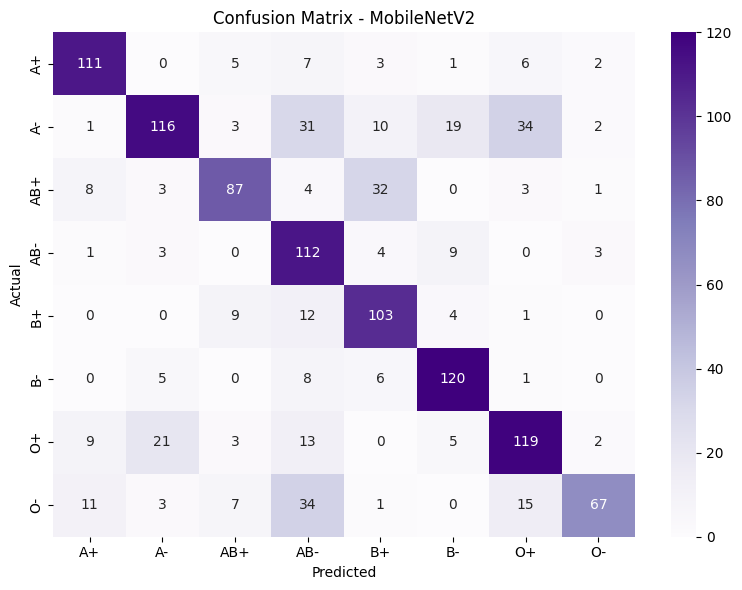

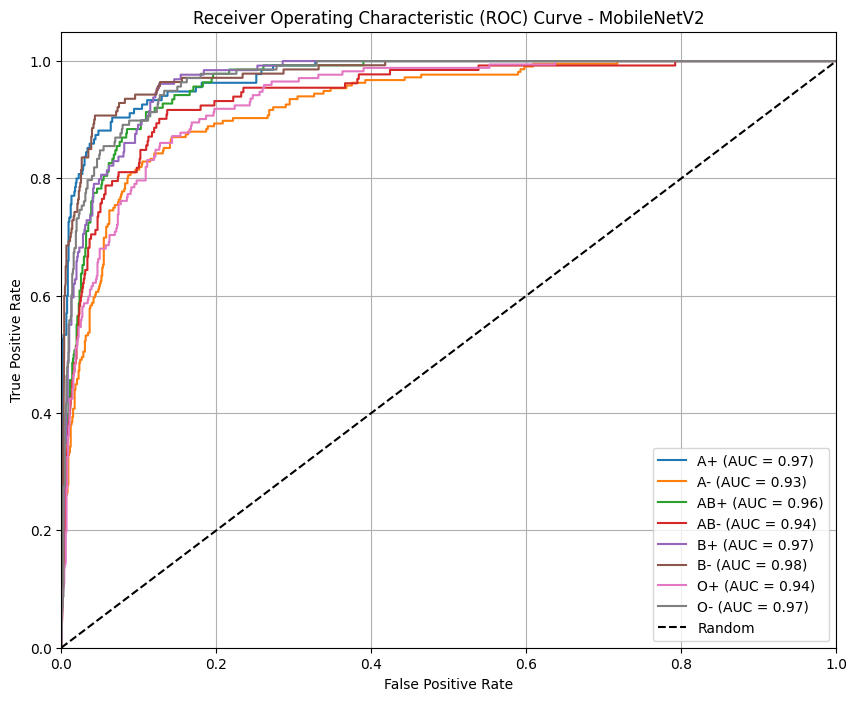

In [ ]:
# Classification Metrics for MobileNetV2
accuracy_mobilenet = accuracy_score(y_test_resized, y_pred_mobilenet.argmax(axis=1))
print(f"MobileNetV2 Model Accuracy: {accuracy_mobilenet:.4f}")

print("MobileNetV2 Classification Report:\n", classification_report(y_test_resized, y_pred_mobilenet.argmax(axis=1), target_names=label_encoder.classes_))

# Confusion Matrix for MobileNetV2
cm_mobilenet = confusion_matrix(y_test_resized, y_pred_mobilenet.argmax(axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mobilenet, annot=True, fmt='d', cmap='Purples', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - MobileNetV2')
plt.tight_layout()
plt.show()

# ROC Curves for MobileNetV2
n_classes = len(label_encoder.classes_)
fpr_mobilenet = dict()
tpr_mobilenet = dict()
roc_auc_mobilenet = dict()
for i in range(n_classes):
    # y_test == i creates a binary array (True/False) for each class
    # y_pred_mobilenet[:, i] gets the predicted probability for the current class
    fpr_mobilenet[i], tpr_mobilenet[i], _ = roc_curve(y_test_resized == i, y_pred_mobilenet[:, i])
    roc_auc_mobilenet[i] = auc(fpr_mobilenet[i], tpr_mobilenet[i])

# Plot ROC curves for MobileNetV2
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr_mobilenet[i], tpr_mobilenet[i], label=f'{label_encoder.classes_[i]} (AUC = {roc_auc_mobilenet[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - MobileNetV2')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


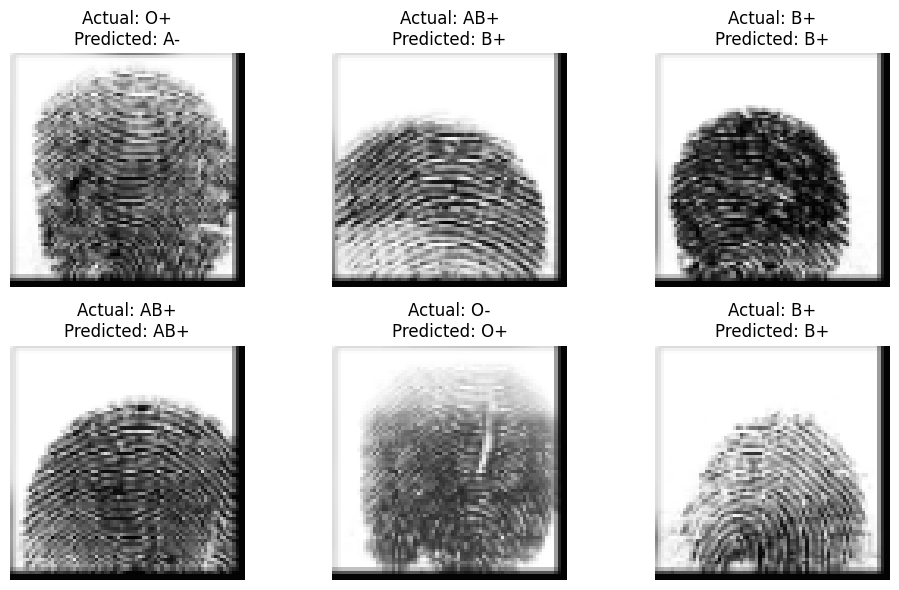

In [ ]:
# Sample Predictions for MobileNetV2
def show_predictions_mobilenet(model, X_test, y_test, label_encoder):
    plt.figure(figsize=(10, 6))

    for i in range(6):  # Show 6 test samples
        idx = random.randint(0, len(X_test) - 1)
        img = X_test[idx] # X_test is already in RGB format here
        actual_label = label_encoder.inverse_transform([y_test[idx]])[0]

        # Predict label
        # Ensure the input shape for prediction is (1, 75, 75, 3)
        pred_prob = model.predict(img.reshape(1, 75, 75, 3))
        pred_label_index = np.argmax(pred_prob)
        pred_label = label_encoder.inverse_transform([pred_label_index])[0]

        plt.subplot(2, 3, i + 1)
        # Rescale pixel values back to 0-255 for display if needed, or adjust cmap
        # If X_test_resized was scaled to 0-1, multiply by 255 for display
        plt.imshow((img * 255).astype(np.uint8))
        plt.title(f"Actual: {actual_label}\nPredicted: {pred_label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_predictions_mobilenet(model_mobilenet, X_test_resized, y_test_resized, label_encoder)